In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

----

## 8.500 Generative Adverserial Networks

A forger produces some fake Picassos

The fakes are mixed with original Picassos and an art dealer classifies the paintings

The forger acts on the dealer's feedback and paints some more fakes

The new fakes are again mixed with originals and the art dealer makes a new assessment, but this time she is better at distinguishing fakes from originals because she has more experience 

Over time, the painter becomes a better forger and the dealer becomes a better critic



A GAN network has 
- a *generator* that takes a random point in the latent space and decodes it into a synthetic imnage
- a *discriminator* predicts whether an image came from the training set or from ther generator.



The generator is trained to fool the discriminator and the discriminator is constantly adapting.

There is no guarantee that the latent space is structured or even continuous.

A GAN does not have a fixed loss landscape (loss plotted against parameters) - the entire landsape changes with each step.

The aim is not minimisation, but equilibrium - and this is difficult and involves a lot of 'alchemy'.

----

## 8.510 Schematics

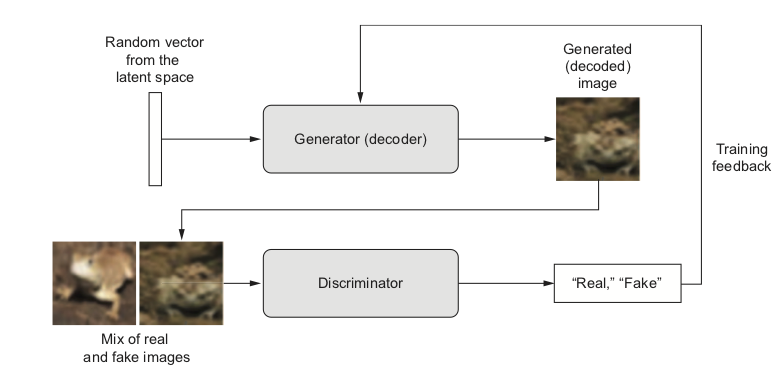

1. A generator maps vectors from the latent space to images. The vectors are random $n$-dimensional vectors (normal distribution) where $n$ is the dimension of the latent space
2. The generated images are mixed with real ones (e.g.) from CIFAR10


3. A discriminator network outputs a binary score in $[0, 1]$ i.e. to a 'probability' for each image in the mixed set
4. The discriminator is frozen 


5. The generator is trained to maximise the discriminator loss i.e. to produce images that the discriminator will classify as real; the discriminator is trained to lower its loss i.e. to become better at spotting fakes

----

## 8.570 Wrapping up

- A GAN is a generator network coupled to a discriminator network
- The discriminator is trained to differentiate generator output from genuine test images
- The generator never sees real images 
- but is trained to fool the discriminator


- GANs are difficult to train because they lack a static loss landscape. There are many tricks, and a lot of training
- GANs can nevertheless generate highly realistic images, but the latent space is almost certainly unstructured and so will not possess concept vectors

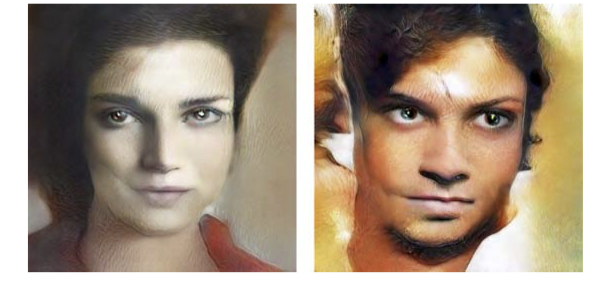

The code in this notebook is from DLWP 2nd edition

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part05_gans.ipynb

----

Get the CelebA data

In [ ]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

Create a dataset from a directory of images

In [ ]:
from tensorflow import keras
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Rescale images

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

Display the first image

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Discriminator

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

GAN model

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
          shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Callback for sampling during training

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")


Compiling and training the GAN

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

import tensorflow as tf # missing from gitlab file, 10/06/21
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)